<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Kaggle-Challenge/blob/master/module1/lesson_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1


#### Objectives
- clean outliers, impute missing values
- use scikit-learn pipelines
- use scikit-learn for decision trees
- understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions
- get and interpret feature importances of a tree-based model

#### Links

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages, if you haven't already:

- [graphviz](https://anaconda.org/anaconda/python-graphviz)
- [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0
- [Plotly](https://plot.ly/python/getting-started/), version >= 4.0

```
conda install python-graphviz
```

```
conda install -c conda-forge category_encoders plotly
```


In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

     |████████████████████████████████| 92kB 3.4MB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 7.1MB 44.4MB/s 
     |████████████████████████████████| 614kB 40.9MB/s 
     |████████████████████████████████| 225kB 42.6MB/s 
     |████████████████████████████████| 768kB 40.2MB/s 
     |████████████████████████████████| 51kB 16.9MB/s 
     |████████████████████████████████| 194kB 44.0MB/s 
     |████████████████████████████████| 737kB 30.2MB/s 
     |████████████████████████████████| 51kB 18.1MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=de6d55418d8d4cf61bad81add7b8adfaca820e31ef5f066a0d534c226c7f36e7
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=3bc8c998c22c061983bee72a325e8ce33560472e5e3a5f4b3b86750f83958f6d
  Stored 

In [0]:
# Use this function later

%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

def pred_heatmap(model, X, features, class_index=-1, title='', num=100):
    """
    Visualize predicted probabilities, for classifier fit on 2 numeric features
    
    Parameters
    ----------
    model : scikit-learn classifier, already fit
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 numeric features
    class_index : integer, index of class label
    title : string, title of plot
    num : int, number of grid points for each feature
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(max2, min2, num)
    combos = list(itertools.product(x1, x2))
    y_pred_proba = model.predict_proba(combos)[:, class_index]
    pred_grid = y_pred_proba.reshape(num, num).T
    table = pd.DataFrame(pred_grid, columns=x1, index=x2)
    plot_every_n_ticks = int(floor(num/4))
    sns.heatmap(table, xticklabels=plot_every_n_ticks, yticklabels=plot_every_n_ticks)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()

## Clean outliers, impute missing values (example solutions)

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

Some of the locations are at ["Null Island"](https://en.wikipedia.org/wiki/Null_Island) instead of Tanzania.

In [30]:
import plotly.express as px
px.scatter(train, x='latitude', y='longitude', color='status_group')

In [31]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37037.915699,321.925261,669.567656,34.082431,-5.705946e+00,0.477736,15.258291,5.616751,179.805513,1302.768939
std,21412.099719,3197.240487,693.005745,6.552053,2.941332e+00,13.312977,17.530228,9.621230,463.081564,950.955437
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18482.750000,0.000000,0.000000,33.092142,-8.528215e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36986.500000,0.000000,372.500000,34.910740,-5.021436e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55450.250000,25.000000,1320.000000,37.170578,-3.327185e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


#### Define a function to wrangle train, validate, and test sets in the same way.

Fix the location, and do more data cleaning and feature engineering.

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

Now the locations look better.

In [33]:
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group')
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

#### Select features

In [34]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Use scikit-learn pipelines

We can combine steps with pipelines: Encode, Impute, Scale, Fit, Predict!

[The Scikit-Learn User Guide explains why pipelines are useful](https://scikit-learn.org/stable/modules/compose.html), and demonstrates how to use them.

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

Here's the documentation for each step in this pipeline:

- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html
- https://contrib.scikit-learn.org/categorical-encoding/onehot.html
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


In [36]:
X_train.isnull().sum()

amount_tsh                  0
gps_height                  0
longitude                1442
latitude                 1442
num_private                 0
region_code                 0
district_code               0
population                  0
construction_year           0
basin                       0
region                      0
public_meeting           2644
recorded_by                 0
scheme_management        3128
permit                   2443
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
dtype: int64

In [38]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)


# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7308922558922559


#### Get and plot coefficients

This is slightly harder when using pipelines.

The pipeline doesn't have a `.coef_` attribute. But the model inside the pipeline does. 

So, here's [how to access steps inside a pipeline](https://scikit-learn.org/stable/modules/compose.html#accessing-steps):

> Pipeline’s `named_steps` attribute allows accessing steps by name

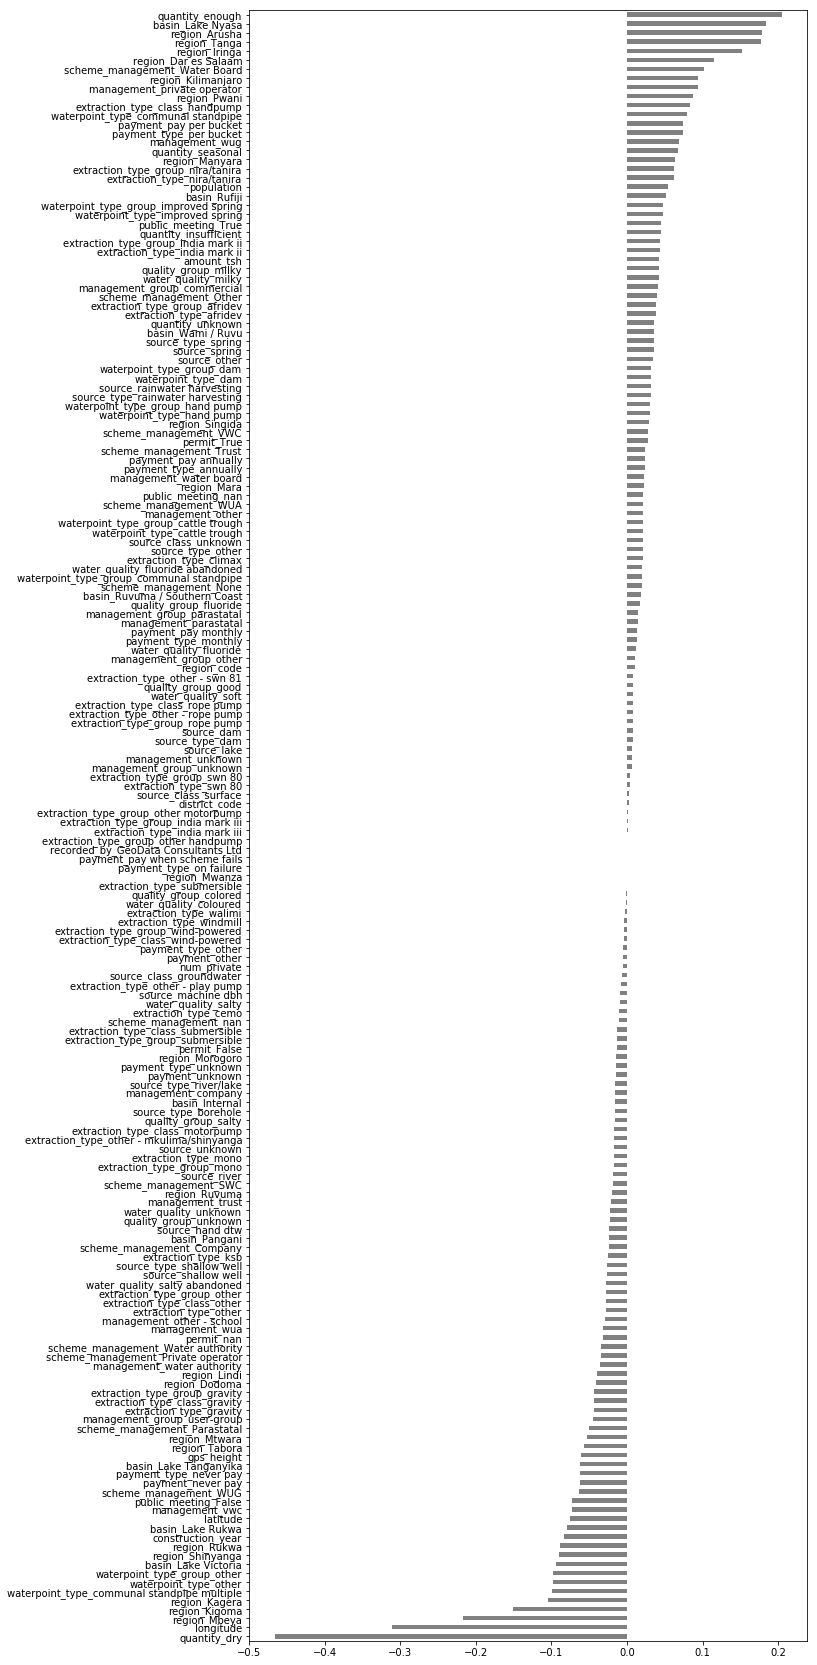

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

## Use scikit-learn for decision trees

### Compare a Logistic Regression with 2 features, longitude & latitude ...

In [0]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [46]:
# With just long & lat, a Logistic Regression can't beat the majority classifier baseline

lr = make_pipeline(
    SimpleImputer(),
    LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
)

# lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
lr.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


### ... versus a Decision Tree Classifier with 2 features, longitude & latitude

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

We will start with default parameters, including:
- `max_depth=None`
- `min_samples_leaf=1`

In [47]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

dt.fit(train_location, y_train)
print('Decision Tree Classifier')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree Classifier
Train Accuracy 0.984196127946128
Validation Accuracy 0.6301346801346801


### ... versus a less complex Decision Tree Classifier 

We can use the `min_samples_leaf` parameter to reduce model complexity.

It's explained in [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Also in [A Visual Introduction to Machine Learning, Part 2](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/):

> Models can be adjusted to change the way they fit the data. These 'settings' are called [hyper]parameters. An example of a decision-tree [hyper]parameter is the _minimum node size_, which regulates the creation of new splits. A node will not split if the number of data points it contains is below the minimum node size.

In [48]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
)

dt.fit(train_location, y_train)
print('Decision Tree Classifier')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree Classifier
Train Accuracy 0.7018939393939394
Validation Accuracy 0.6501683501683502


### Visualize the logistic regression predictions

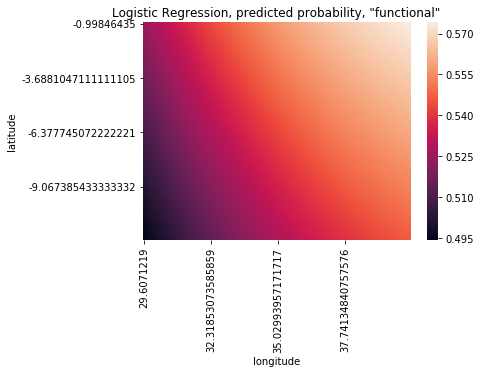

In [50]:
pred_heatmap(lr, train_location, features=['longitude', 'latitude'], class_index=0, title='Logistic Regression, predicted probability, "functional"')

### Visualize the decision tree predictions

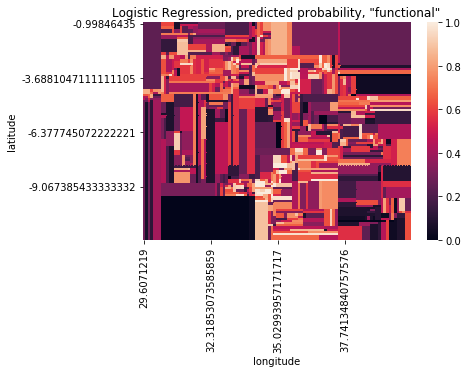

In [51]:
pred_heatmap(dt, train_location, features=['longitude', 'latitude'], class_index=0, title='Logistic Regression, predicted probability, "functional"')

### How does a tree grow? Branch by branch!

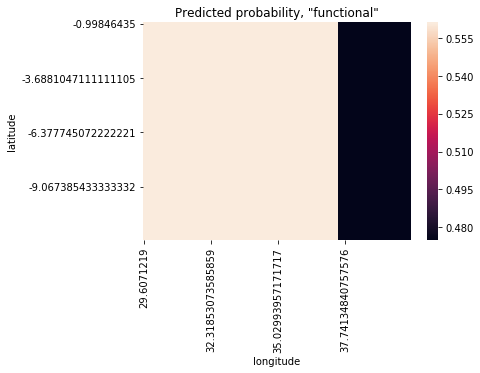

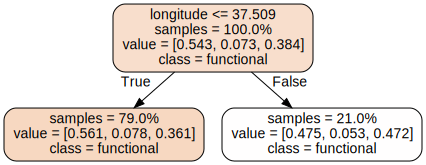

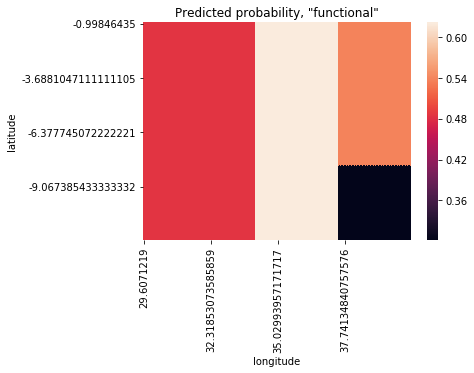

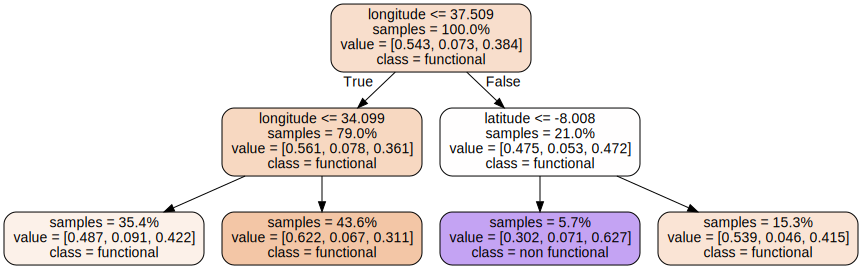

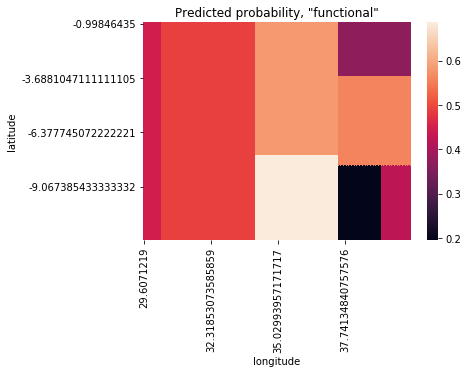

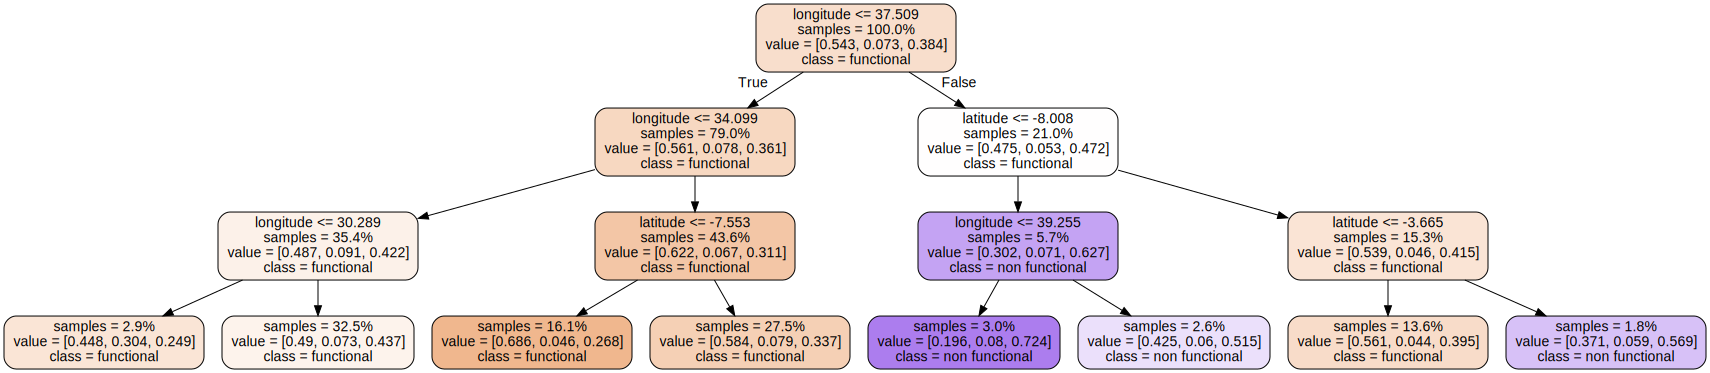

In [52]:
from IPython.display import display, HTML
import graphviz
from sklearn.tree import export_graphviz

for max_depth in [1,2,3]:
    
    # Fit decision tree
    dt = make_pipeline(
        SimpleImputer(), 
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    dt.fit(train_location, y_train)
    
    # Display depth & scores
    display(HTML(f'Max Depth {max_depth}'))
    display(HTML(f'Train Accuracy {dt.score(train_location, y_train):.2f}'))
    display(HTML(f'Validation Accuracy {dt.score(val_location, y_val):.2f}'))
    
    # Plot heatmap of predicted probabilities
    pred_heatmap(dt, train_location, features=['longitude', 'latitude'], 
                 class_index=0, title='Predicted probability, "functional"')
    
    # Plot tree
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
    dot_data = export_graphviz(dt.named_steps['decisiontreeclassifier'], 
                               out_file=None, 
                               max_depth=3, 
                               feature_names=train_location.columns,
                               class_names=dt.classes_, 
                               impurity=False, 
                               filled=True, 
                               proportion=True, 
                               rounded=True)   
    display(graphviz.Source(dot_data))

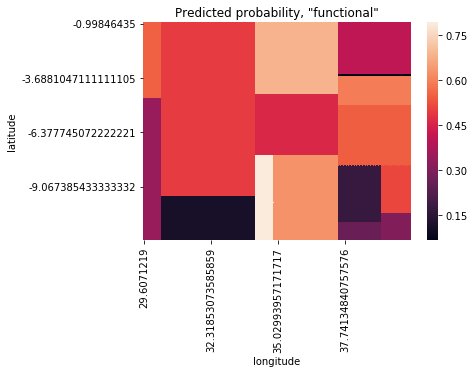

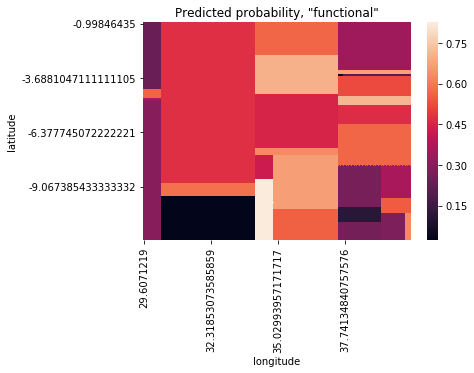

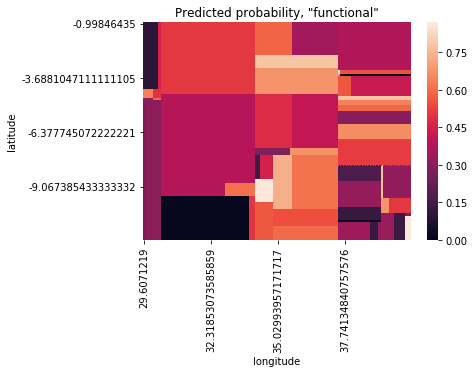

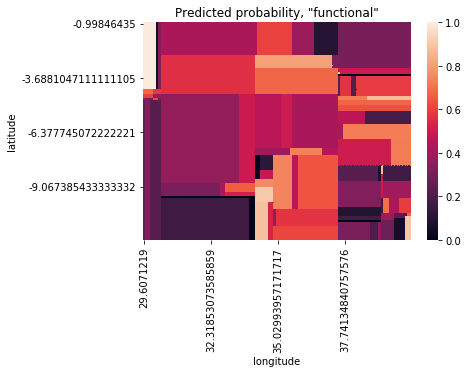

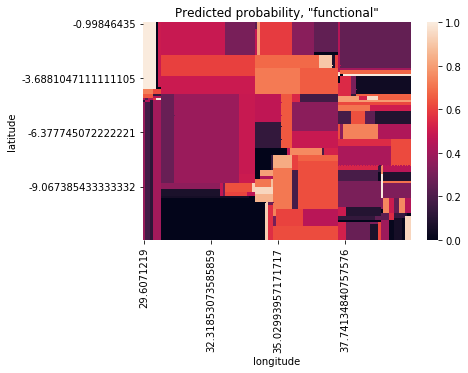

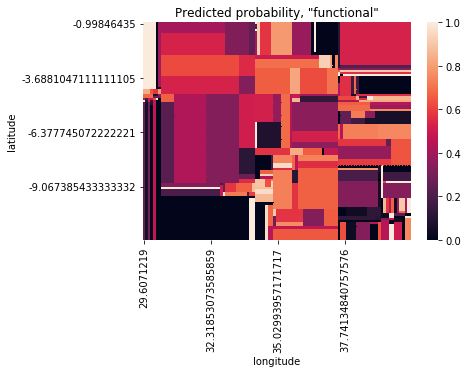

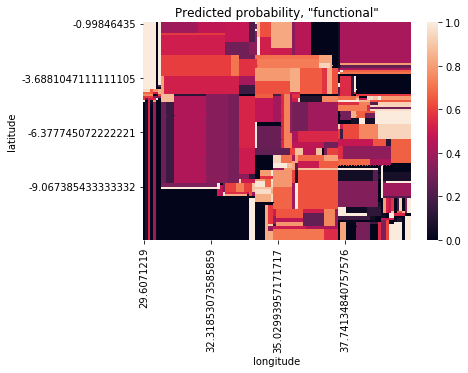

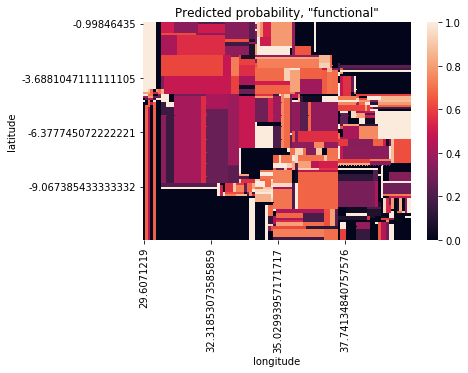

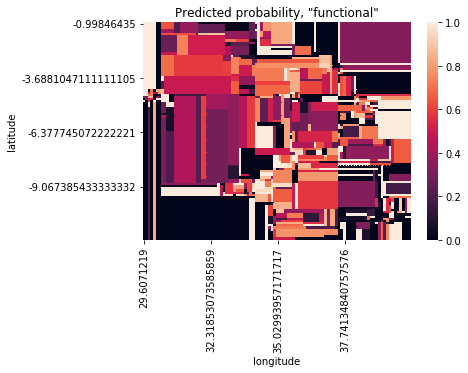

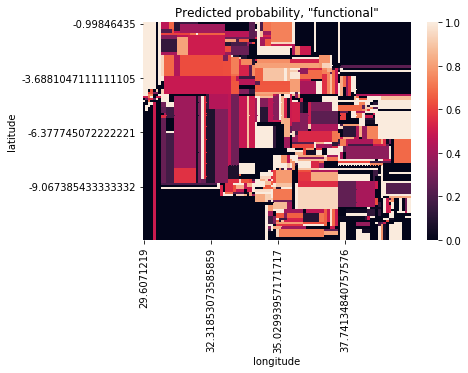

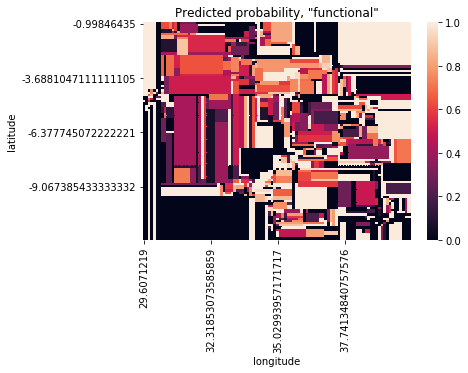

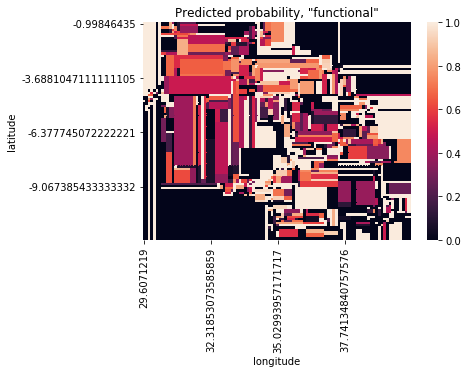

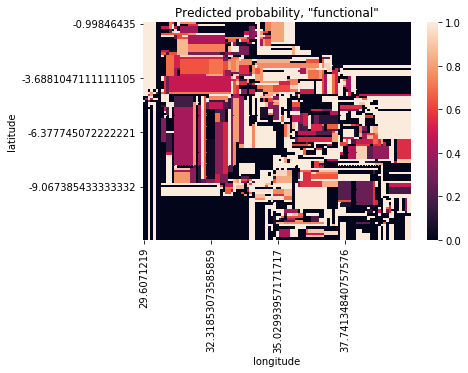

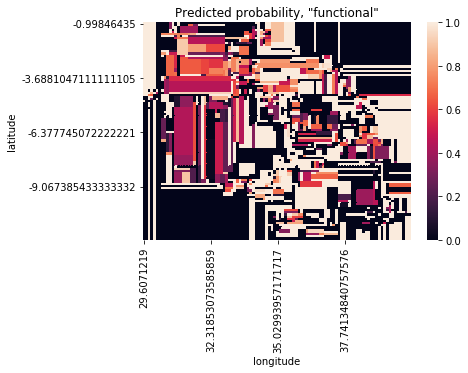

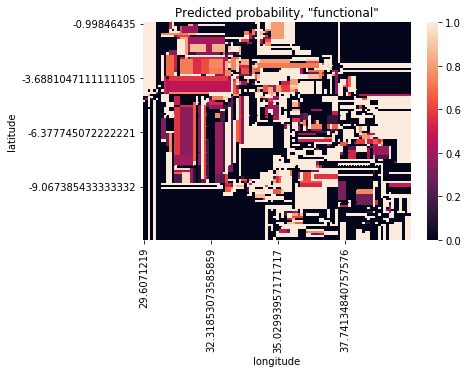

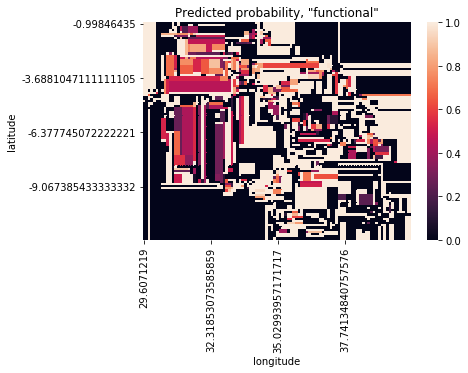

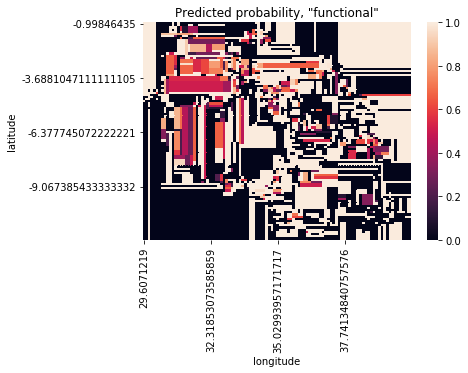

In [53]:
for max_depth in range(4,21):
    
    # Fit decision tree
    dt = make_pipeline(
        SimpleImputer(), 
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    dt.fit(train_location, y_train)
    
    # Display depth & scores
    display(HTML(f'Max Depth {max_depth}'))
    display(HTML(f'Train Accuracy {dt.score(train_location, y_train):.2f}'))
    display(HTML(f'Validation Accuracy {dt.score(val_location, y_val):.2f}'))
    
    # Plot heatmap of predicted probabilities
    pred_heatmap(dt, train_location, features=['longitude', 'latitude'], 
                 class_index=0, title='Predicted probability, "functional"')

## Understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions

#### What does _(non)monotonic_ mean?!?!
- See Figures 1-3 in Wikipedia's article, [Monotonic function](https://en.wikipedia.org/wiki/Monotonic_function)
- See [World Population Growth, 1700-2010](https://ourworldindata.org/world-population-growth-past-future). World Population is non-linear and monotonic. Annual growth rate is non-linear and non-monotonic.
- See [Accidents per Mile Driven, by Driver Age](http://howwedrive.com/2009/02/20/whats-the-real-risk-of-older-drivers/). This is non-linear and non-monotonic.

#### What does _feature interactions_ mean?!?!
- See the explanation in [_Interpretable Machine Learning_, Chapter 5.4.1, Feature Interaction](https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction).
- See the exploration in this notebook, under the heading ***Interlude #2: Simple housing***

### Interlude #1: predicting golf putts
(1 feature, non-linear, regression)

https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/

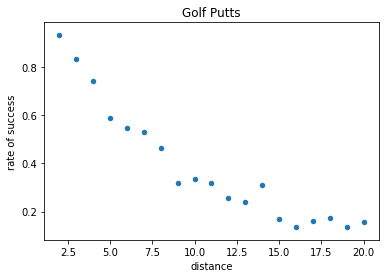

In [55]:
columns = ['distance', 'tries', 'successes']
data = [[2, 1443, 1346],
        [3, 694, 577],
        [4, 455, 337],
        [5, 353, 208],
        [6, 272, 149],
        [7, 256, 136],
        [8, 240, 111],
        [9, 217, 69],
        [10, 200, 67],
        [11, 237, 75],
        [12, 202, 52],
        [13, 192, 46],
        [14, 174, 54],
        [15, 167, 28],
        [16, 201, 27],
        [17, 195, 31],
        [18, 191, 33],
        [19, 147, 20],
        [20, 152, 24]]

putts = pd.DataFrame(columns=columns, data=data)
putts['rate of success'] = putts['successes'] / putts['tries']
putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts');

#### Compare Linear Regression ... 

R^2 Score 0.8695850610243295


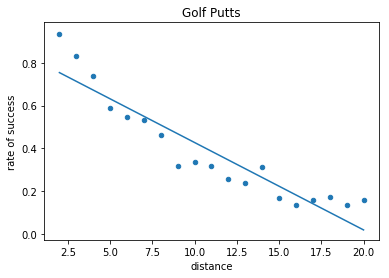

In [56]:
from sklearn.linear_model import LinearRegression

putts_X = putts[['distance']]
putts_y = putts['rate of success']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
ax.plot(putts_X, lr.predict(putts_X));

#### ... versus a Decision Tree Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [57]:
import graphviz
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
    ax.step(putts_X, tree.predict(putts_X), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['distance']))

interact(putts_tree, max_depth=(1,6,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

### Interlude #2: Simple housing 
(2 features, regression)

https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

In [58]:
columns = ['Price', 'Good Location', 'Big Size']

data = [[300000, 1, 1], 
        [200000, 1, 0], 
        [250000, 0, 1], 
        [150000, 0, 0]]

house = pd.DataFrame(columns=columns, data=data)
house

,Price,Good Location,Big Size
0,300000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [59]:
house_X = house.drop(columns='Price')
house_y = house['Price']
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 1.0
Intercept 	 150000.0
Good Location     50000.0
Big Size         100000.0


#### ... versus a Decision Tree Regressor

R^2 1.0


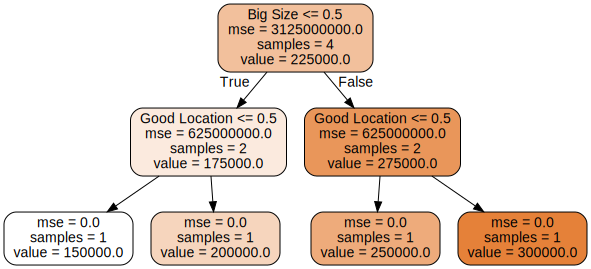

In [60]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

### Simple housing, with a twist: _Feature Interaction_

In [61]:
house.loc[0, 'Price'] = 400000
house_X = house.drop(columns='Price')
house_y = house['Price']
house

,Price,Good Location,Big Size
0,400000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [62]:
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 0.9285714285714286
Intercept 	 125000.0
Good Location    100000.0
Big Size         150000.0


#### ... versus a Decision Tree Regressor

R^2 1.0


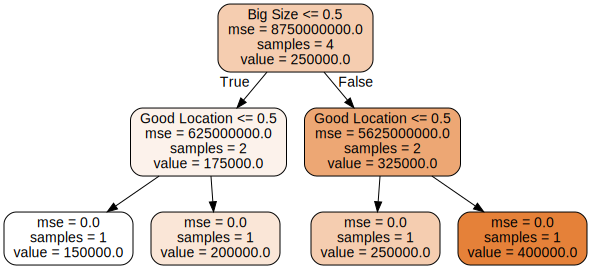

In [63]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

## Get and interpret feature importances of a tree-based model

In [64]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=15, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8321338383838384
Validation Accuracy 0.7671717171717172


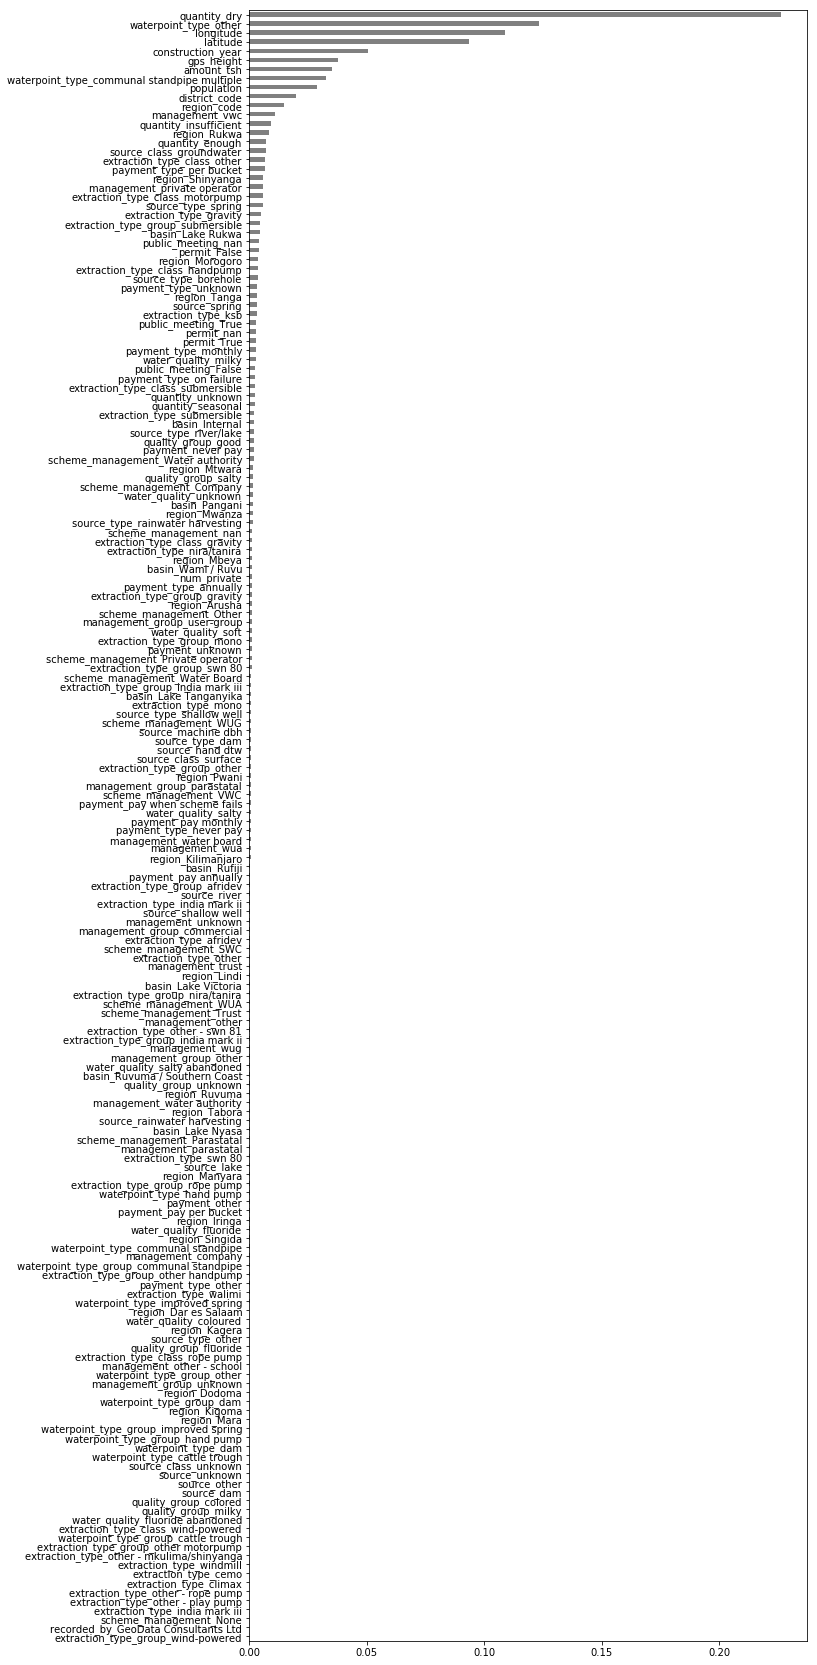

In [66]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');